# LCP Final Project

This is my personal notebook containing the draft of all the functions and the code necessary for my own implementation, together with any kind of material deemed useful to the purpose.

GUI implementation and subsequent merging will be crucial additions.

## Introduction 

We are presented with a dataset obtained by four drift-tube detectors during a beam test. The detectors are filled with a gas mixture and they are divided in four layers, each made of cells with an anodic wire sitting at the center; their purpose is to measure the time of flight of $e^-$ drifting towards the anode after the gas has been ionized by the passage of particles through it.

The main purpose of our research is to study properties of $\mu^+ - \mu^-$ pairs produced by positrons colliding at $E=45$ GeV energy onto a Berillium target. 

The data-taking process consists of two phases: a calibration one, where only $\mu^+$ at given energies are employed; the sign of the current powering the magnet is changed so as to have alternance of track directions.

## Outline

We briefly present the outline of our research contained in this document. Note that the code related to the functions that have been created specifically for this project can be found in a separate module.


## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

from scipy import stats
from math import fabs

%matplotlib inline

## Preliminary utilities

Below we copy the paths for calibration and physics data; the folders contain .txt files.

In [2]:
path_cal = "./Final\ Project\ \(group6\)/data/calibration/" # + "Run000260" & 261,262,263

In [3]:
path_phys = "./Final\ Project\ \(group6\)/data/physics/" # + "Run000331" & 332 to 339

In [4]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

**Transformations**

```python
x_global =  global_x_shifts[chamber] - x_local
```
(*negative sign is due to 180° degrees rotation of detectors*)

```python
z_local = local_z_shifts[layer]
z_global = global_z_shifts[chamber] + z_local
```

## Functions
### Read data

* **Input**: 1 row of data_file.txt, e.g. 1 event, passed as a list
* **Output**: pandas dataframe as in the Data Format paragraph, Number of the Event, Number of hits in the Event

This function takes in input one event at time, and then outputs a pandas dataframe as described in the previous section. In addition, the transformation from local to global coordinates is performed.


In [5]:
data_file = "./Final Project (group6)/data/calibration/Run000260/data_000000.txt"
with open(data_file) as f:
    line = f.readline()
    line = f.readline()
    line = f.readline()
    line = f.readline()
    line = f.readline()
    event = line.split()
    #event = [float(i) for i in event]
    print(event)

['5', '11', '2', '2', '7.695e+01', '9.105e+01', '130.8', '2', '3', '4.967e+01', '7.633e+01', '247.5', '2', '4', '7.494e+01', '9.306e+01', '168.3', '2', '1', '4.833e+01', '7.767e+01', '272.5', '3', '4', '4.160e+01', '4.240e+01', '7.5', '3', '3', '1.869e+02', '1.911e+02', '39.2', '3', '2', '4.065e+01', '4.335e+01', '25.0', '3', '1', '1.421e+02', '1.519e+02', '91.7', '3', '4', '1.532e+02', '1.828e+02', '275.0', '3', '1', '4.362e+01', '8.238e+01', '360.0', '3', '3', '4.312e+01', '8.288e+01', '369.2']


In [6]:
def read_data(event):    
    event_number = int(event[0])
    hits_number  = int(event[1])
    hit       = np.arange(hits_number)
    chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)
    layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)
    xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)
    xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)
    z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)
    time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)
    xl_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xl_local
    xr_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xr_local
    z_global  = np.fromiter((global_z_shifts[i] for i in chamber), float) + z_local
    dataframe = pd.DataFrame(
        { 'EvNumber' : event_number,
          'Hit'      : hit,
          'Chamber'  : chamber,
          'Layer'    : layer,
          'XL_local' : xl_local,
          'XR_local' : xr_local,
          'Z_local'  : z_local,
          'Time'     : time,
          'XL_global': xl_global,
          'XR_global': xr_global,
          'Z_global' : z_global,
        })
    #dataframe.set_index('Hit', inplace=True) # set as index the number of the hit 
    return dataframe, event_number, hits_number

In [7]:
ev, evNumber, hits = read_data(event)
ev["EvNumber"][0]

5

### Event selection

- **Input**: Pandas `DataFrame` (1 event)
- **Output**: True/False

The input of the function is the Pandas `DataFrame` made by the *Read Data* function. The output is a boolean value, which labels the good calibration events.
We need to plot the histogram of the frequency of the number of hits, in order to find out the best requirements for good events.

*Possible choice (to be evaluated)*: Good events requires at least 6 hits (in different layers) either in the left or in the right side of the detector.

In [8]:
def select_events(dataframe):
        
        #hits only in the left side
        if((dataframe['Chamber']<=1).all()):
            #compute number of different layers in each chamber
            n_layer_ch0 = dataframe[dataframe['Chamber']==0]['Layer'].nunique()
            n_layer_ch1 = dataframe[dataframe['Chamber']==1]['Layer'].nunique()
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch0>=3 and n_layer_ch1>=3):
                return True
            else:
                return False
            
        #hits only in the right side
        elif((dataframe['Chamber']>=2).all()):
            #compute number of different layers in each chamber
            n_layer_ch2 = dataframe[dataframe['Chamber']==2]['Layer'].nunique()
            n_layer_ch3 = dataframe[dataframe['Chamber']==3]['Layer'].nunique() 
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch2>=3 and n_layer_ch3>=3):
                return True
            else:
                return False
        
        #hits in both left and right side
        else:
            return False
    
#print(select_events(ev))            
#print(ev)

### Plot background

- **Input**: `None`
- **Output**: `list`[pyplot `Axes`] (global image + 4 detectors zooms)

Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. This function is made in order to do the plot of the background only one time, instead of doing that for every Event.

In order to plot the `Axes` in the `list`, and get a good layout:
```python
gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
plt.show()
```

In [9]:
def plot_background():
    # create Pandas DataFrame for the cambers positions
    chamber_position = pd.DataFrame({
    'chamber' : [i for i in range(4)],
    'x_vertices' : [(global_x_shifts[i], global_x_shifts[i] - 720, global_x_shifts[i] - 720, global_x_shifts[i])
                    for i in range(4)],
    'y_vertices' : [(global_z_shifts[i], global_z_shifts[i], global_z_shifts[i] + 52, global_z_shifts[i] + 52)
                    for i in range(4)],
    })
    x_lim = [[-1000, 1000], # global detector
             [    0, 1000], # chamber 0
             [    0, 1000], # chamber 1
             [-1000,    0], # chamber 2
             [-1000,    0]] # chamber 3
    y_lim = [[-100, 1000],  # global detector
             [800 ,  900],  # chamber 0
             [ -25,   75],  # chamber 1
             [ 800,  900],  # chamber 2
             [ -25,   75]]  # chamber 3
    title = ["DETECTOR", "Chamber 0", "Chamber 1", "Chamber 2", "Chamber 3"]
    # create pyplot 'Axes' objects
    ax_global = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax_0 = plt.subplot2grid(gridsize, (2, 1), colspan=1, rowspan=1) # top-right
    ax_1 = plt.subplot2grid(gridsize, (3, 1), colspan=1, rowspan=1) # bottom-right
    ax_2 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=1) # top-left
    ax_3 = plt.subplot2grid(gridsize, (3, 0), colspan=1, rowspan=1) # bottom-left
    
    axes = [ax_global, ax_0, ax_1, ax_2, ax_3]
    for index, ax in enumerate(axes):
        ax.set_xlim(x_lim[index])
        ax.set_ylim(y_lim[index])
        ax.set_xlabel("x [mm]")
        ax.set_ylabel("z [mm]")
        if index == 0: ax.set_title(title[index])
        else: ax.set_title(title[index], pad=-20)
        # plot the 4 chambers in each 'Axes'
        for j in range(4):
            chamber = chamber_position[chamber_position["chamber"] == j]
            ax.fill(chamber["x_vertices"].values[0], chamber["y_vertices"].values[0], color='gray', fill=False)
    return axes

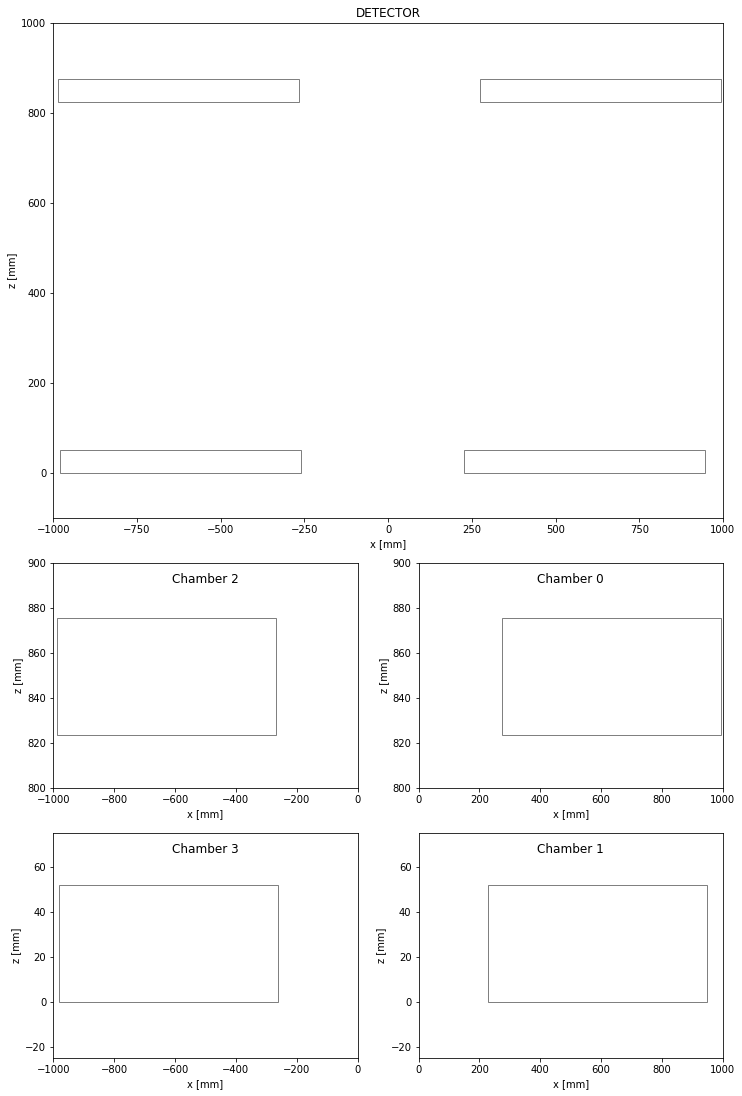

In [10]:
gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
plt.show()

### Plot events

- **Input**: Pandas `DataFrame` (1 event) + event number
- **Output**: `list`\[pyplot `Axes`\] (global image + 4 detectors zooms)

The input of the function is the Pandas `DataFrame` made by the *Read Data* function, and the event number (this is due to the fact that, if the are no hits, the `DataFrame` is empty, and therefore we can't get the Event number from that). Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. In the images there will be the points of the hits tracked in the event (left/right positions must have different colors).

In [11]:
def plot_events(dataframe, evNumber):
    # get the EvNumber as argument, because, if the dataframe is empty,
    # I can't get it from data
    plots = plot_background()
    plots[0].set_title("Event:"+str(evNumber), {'size':'18'})
    if dataframe.empty == False:
        xL = dataframe["XL_global"]
        xR = dataframe["XR_global"]
        z  = dataframe["Z_global"]
        for index, image in enumerate(plots):     
            image.plot(xL, z, "bo", markersize=3)
            image.plot(xR, z, "ro", markersize=3)
    return plots

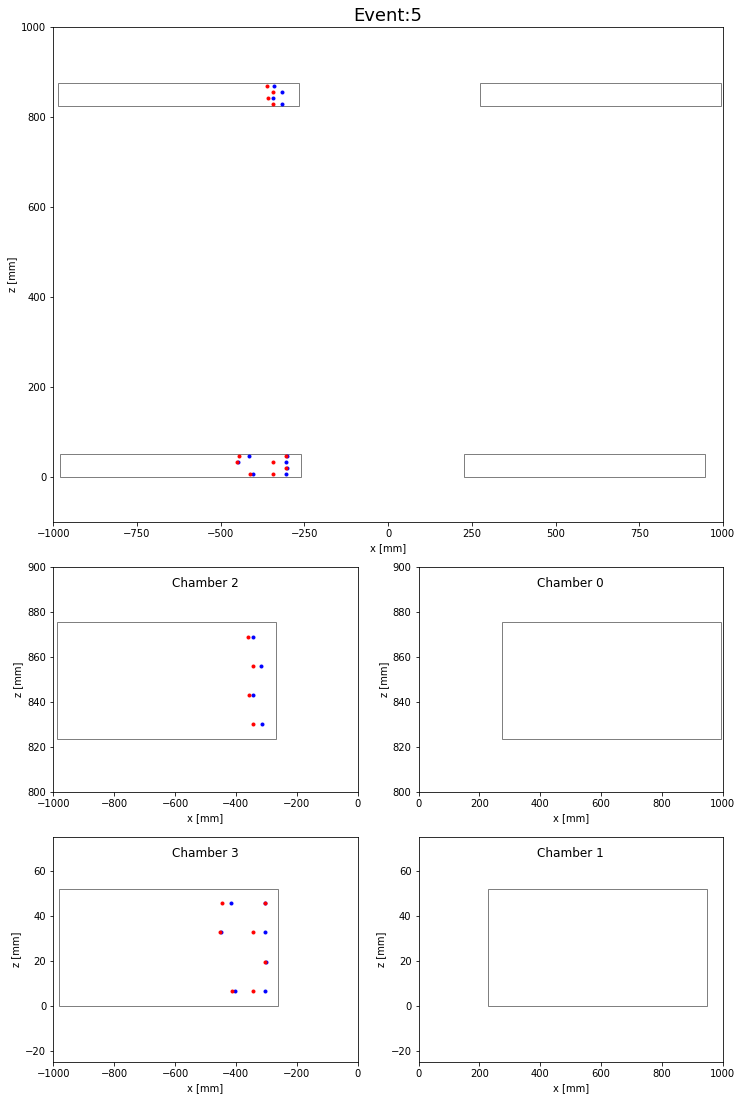

In [12]:
gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
axes = plot_events(ev, evNumber)
plt.show()

### Select Events (Calibration)

* **Input**: Pandas `DataFrame`
* **Output**: True/False, list with involved chambers numbers, list with number of different layers per chamber

The input of the function is the Pandas DataFrame made by the Read Data function. The output is a boolean value, which labels the good calibration events, a list with the number of the chambers involved (0,1) or (2,3), and a list with the number of hit layers for each chamber.

Good events requires at least 3 hits in different layers for each chamber, either in the left or in the right side of the detector.

In [ ]:
def select_events(dataframe):
        
        #hits only in the right side
        if((dataframe['Chamber']<=1).all()):
            chambers=[0,1]
            #compute number of different layers in each chamber
            n_layer_ch0 = dataframe[dataframe['Chamber']==0]['Layer'].nunique()
            n_layer_ch1 = dataframe[dataframe['Chamber']==1]['Layer'].nunique()
            
            n_layer=[n_layer_ch0, n_layer_ch1]
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch0>=3 and n_layer_ch1>=3):
                select=True
                return select, chambers, n_layer
            else:
                select=False
                return select, chambers, n_layer
            
        #hits only in the left side
        elif((dataframe['Chamber']>=2).all()):
            chambers=[2,3]
            #compute number of different layers in each chamber
            n_layer_ch2 = dataframe[dataframe['Chamber']==2]['Layer'].nunique()
            n_layer_ch3 = dataframe[dataframe['Chamber']==3]['Layer'].nunique() 
            
            n_layer=[n_layer_ch2, n_layer_ch3]
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch2>=3 and n_layer_ch3>=3):
                select=True
                return select, chambers, n_layer
            else:
                select=False
                return select, chambers, n_layer
        
        #hits in both left and right side
        else:
            select=False
            chambers=[]
            n_layer=[]
            return select, chambers, n_layer                  
        
    
print(select_events(ev))            
print(ev)
condition, chambers, n_layers= select_events(ev)
print(condition)

### Local linear fit

* **Input**: Pandas DataFrame, list with involved chambers numbers ([0,1] or [2,3]), list with number of different layers per chamber
* **Output**: list of 2 dictionaries, one for each chamber, containing fit results

The inputs of the function are the Pandas DataFrames made by the `Read data` function, and the two lists returned by the `Select events` function. 
The fit is only made for good events, which means the return of Select Events (Calibration) function is True. If there are no hits in the chamber, the list returned should be [False, False].
The output is a list of 2 dictionaries, one for each chamber, containing slope, intercept, numpy array with best combination of points and number of the excluded layer.
The best combination of points is the one with the lowest $\chi^2$.

In [13]:
def local_fit(dataframe, list_chambers, list_layers):
    #list to store results for each chamber
    results=[]
    #loop over the (two) chambers
    for i in range(0,len(list_chambers)):
       #if we have 4 different layers we randomly select a layer to be excluded
       #we will use the point from the excluded layer to check the goodness of the global fit
        if(list_layers[i]==4):
            rand_layer=random.randint(1,4)
        else:
            rand_layer=0 #layers are 1,2,3,4: excluding layer 0 is equivalent to keeping them all
        
        #create dataframe_cl filtered by chamber and excluded layer
        dataframe_c = dataframe[dataframe['Chamber']==list_chambers[i]] #dataframe filtered by chamber
        dataframe_cl = dataframe_c[dataframe_c['Layer']!=rand_layer]    #filtered by chamber and excluded layer
        
        # Z local coordinates corresponding to the 4 different layers
        Z=[6.5,19.5, 32.5, 45.5]
        
        #create a list l containing 3 lists of points (z,x), one for each selected layer
        l=[]
        
        #loop over selected layers and fill l
        for layer_index in dataframe_cl['Layer'].unique():
            XR=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XR_local'])
            XL=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XL_local'])
            
            z=Z[(layer_index-1)] #layer_index is in range [1,4], list index must be in range [0,3]
            l_temp=[]
            
            for x in XR:
                l_temp.append((z,x))
            for x in XL:
                l_temp.append((z,x)) 
            l.append(l_temp) 
            
        #create numpy array with all possible combinations of 3 points p1,p2,p3
        combinations=np.array([(p1,p2,p3) for p1 in l[0] for p2 in l[1] for p3 in l[2]])
        
        #interpolate each combination and select the combination with least chi squared
        min_chisq=100000 #to store minimum chisq
        optimal_comb=np.zeros((3,2)) #to store best combination of points
        slope_opt=0 #to store slope obtained with the best combination
        intercept_opt=0 #to store intercept obtained with the best combination
        for points in combinations:
            #linear regression
            slope, intercept, r_value, p_value, std_err=stats.linregress(points[:,0],points[:,1])
            #compute expected x using the interpolating function
            expect_x=intercept+slope*(points[:,0])
            #compute chi squared
            chisq, p_value=stats.chisquare(points[:,1],expect_x)
            #eventually update min_chisq and optimal_comb
            if(chisq<min_chisq):
                min_chisq=chisq
                optimal_comb=points
                slope_opt=slope
                intercept_opt=intercept
            else:
                continue
                  
        #add to results: results is a list of 2 dictionaries, one for each chamber       
        results.append({"slope":slope_opt, 
                        "intercept":intercept_opt, 
                        "optimal_comb": optimal_comb, 
                        "excl_layer": rand_layer})
                   
    return results
        
        

    
    
print(ev)    
condition, chambers, n_layers=select_events(ev)    
if(condition==True):
    lf_results=local_fit(ev, chambers, n_layers)
    print("Prima camera\n",lf_results[0])
    print("Seconda camera\n", lf_results[1])

    EvNumber  Hit  Chamber  Layer  XL_local  XR_local  Z_local   Time  \
0          5    0        2      2     76.95     91.05     19.5  130.8   
1          5    1        2      3     49.67     76.33     32.5  247.5   
2          5    2        2      4     74.94     93.06     45.5  168.3   
3          5    3        2      1     48.33     77.67      6.5  272.5   
4          5    4        3      4     41.60     42.40     45.5    7.5   
5          5    5        3      3    186.90    191.10     32.5   39.2   
6          5    6        3      2     40.65     43.35     19.5   25.0   
7          5    7        3      1    142.10    151.90      6.5   91.7   
8          5    8        3      4    153.20    182.80     45.5  275.0   
9          5    9        3      1     43.62     82.38      6.5  360.0   
10         5   10        3      3     43.12     82.88     32.5  369.2   

    XL_global  XR_global  Z_global  
0     -344.35    -358.45     843.0  
1     -317.07    -343.73     856.0  
2     -342.3

TypeError: 'bool' object is not iterable

### Global linear fit

* **Input**: Pandas `DataFrame`, list with involved chambers numbers, output list of local fit function
* **Output**: Dictionary containing fit results

The input of the function are the Pandas `DataFrame` made by the `Read data` function, the list with involved chambers numbers returned by the select_events function and the list of 2 dictionaries returned by the local_fit function. The output is a dictionary containing slope, intercept and a numpy array with residuals computed for the eventual test layers.

*Nota provvisoria*: in questo caso non credo si possa calcolare il chi quadro poiché le x possono essere negative. Per il test del chi quadro il valore atteso deve essere positivo (di solito sono frequenze), altrimenti viene un chi quadro negativo (??)

In [ ]:
def global_fit(dataframe, list_chambers, lfit_results):
    
    #TRANSFORM LOCAL COORDINATES IN GLOBAL COORDINATES
    
    #First chamber:
    global_z_ch1 = global_z_shifts[list_chambers[0]]+lfit_results[0]["optimal_comb"][:,0]
    global_x_ch1 = global_x_shifts[list_chambers[0]]-lfit_results[0]["optimal_comb"][:,1]
    global_ch1=np.column_stack((global_z_ch1, global_x_ch1))
    
    #Second chamber:
    global_z_ch2 = global_z_shifts[list_chambers[1]]+lfit_results[1]["optimal_comb"][:,0]
    global_x_ch2 = global_x_shifts[list_chambers[1]]-lfit_results[1]["optimal_comb"][:,1]
    global_ch2=np.column_stack((global_z_ch2, global_x_ch2))
    
    points=np.concatenate((global_ch1, global_ch2))
    #print(points)
    #LINEAR REGRESSION
    slope, intercept, r_value, p_value, std_err=stats.linregress(points[:,0],points[:,1])
    
    #compute expected x using the interpolating function
    expect_x=intercept+slope*(points[:,0])
        
    #COMPUTE RESIDUALS USING TEST LAYER (layer excluded in local fit function)
    # Z local coordinates corresponding to the 4 different layers
    Z_local=[6.5,19.5, 32.5, 45.5]
    #list to store residuals
    res=[]
    #compute residuals for each chamber
    for c in range(0,len(list_chambers)):
        dataframe_c = dataframe[dataframe['Chamber']==list_chambers[c]] #dataframe filtered by chamber
        res_temp=[]
        excl_layer=lfit_results[c]["excl_layer"]
        #test layer Z global coordinate 
        Z_test_layer=global_z_shifts[c]+Z_local[(excl_layer-1)]
        #if there were only 3 layers, excl_layer was set to 0:
        if(excl_layer!=0): 
            expect_x=intercept+slope*(Z_test_layer)
            XR=np.array(dataframe_c[dataframe_c['Layer']==excl_layer]['XR_global'])
            XL=np.array(dataframe_c[dataframe_c['Layer']==excl_layer]['XL_global'])
            for i in range(0,XR.size):
                res_temp.append(XR[i]-expect_x)
            for i in range(0,XL.size):
                res_temp.append(XL[i]-expect_x)
                
            res_temp.sort(key=fabs) #we want the smallest residual in absolute value
            res.append(res_temp[0])
        else:
            res=[]
    #convert list res in numpy array  
    res=np.array(res) 
    #plt.plot(points[:,0],points[:,1], 'o')
    #plt.plot(points[:,0],intercept+slope*points[:,0], 'r')
    #plt.show()
    return {"slope": slope, "intercept": intercept, "residuals": res }
    
gf_results=global_fit(ev, chambers, lf_results)
print(gf_results)

## Note a contorno

* Come errore sulla $x=x(z)$ prediligiamo a quello ricavato a posteriori dal fit un errore ottenuto dal $\sigma$ della posizione del filo ottenuta mediando $x_L$ e $x_R$.


* Local fit permette di eliminare l'ambiguità tra $x_L$ e $x_R$; global fit offre una modalità per testare, qualora vi siano punti aggiuntivi, la bontà del fit: si verifica che l'errore di $y_{fit}$ nel punto non considerato sia ragionevolmente entro le 3$\sigma$. 


* Valutiamo l'eventuale presenza di errore sistematico verificando che la gaussiana dei residui del fit di $x(z)$ sia centrata in 0; la FWHM della gaussiana stessa dovrebbe essere la risoluzione (*da verificare*)


* Proposta per calcolare l'errore dell'efficienza di selezione: $\sigma_{\varepsilon} = \sqrt{\frac{\varepsilon (1-\varepsilon)}{N_2}}$ where $\varepsilon = \frac{N_1}{N_2}$, essendo $N_1$ il numero degli eventi con 8 hits e $N_2$ con 7 hits.


* Dataframe per ogni run in calibrazione; dataframe con tutti gli hit (meglio unire che ciclare) in modo da avere una visione di insieme (utile per istogrammi di frequenza, efficienza, ...); in Physics si possono unire diversi run (effettuati sotto le medesime condizioni)


* Nella scelta del $\chi^{2}$ migliore usiamo solo 3 punti: il quarto va escluso a priori? O solo dopo aver verificato quale combinazione effettivamente abbia $\chi^{2}$ minore?


* Come trovare fit globale: combinazione migliore di ogni camera dal fit locale e rifittiamo O rifacciamo tutte le combinazioni con i punti da capo? Primo modo permette di valutare meglio l'allineamento delle camere

## Osservazioni da riesaminare - fase 2

* Si deve capire come effettuare l'esclusione per scegliere il fit migliore a livello locale: escludiamo un layer a caso e basta, andando a considerare le possibili combinazioni tra quelli rimasti? Consideriamo di escludere tutti i layer e selezioniamo il miglior fit in assoluto (possibile bias rispetto ad eliminare un layer a random)? Consideriamo o no la comparazione con il fit con tutti e 4 i layer?
* Capire come intendere la selezione dei 3 hit su 4: cosa fare in caso di molteplicità? Efficienza?


* La soglia di accettazione per il fit globale è almeno 6 hit? O 7 (troppo alta?)? E si ricostruisce a partire dal miglior risultato locale?
* Come trovare fit globale: combinazione migliore di ogni camera dal fit locale e rifittiamo O rifacciamo tutte le combinazioni con i punti da capo? Primo modo permette di valutare meglio l'allineamento delle camere
Scegliamo la prima soluzione: un fit globale opera sugli eventi con almeno 6 hit (o più); cerca la combinazione migliore (chi quadro minore) di fit tra quelle possibili, escludendo a random un layer; questo genera un fit globale che dovrebbe rappresentare la traccia fisica della particella (-> confronto fit locale comunque per verificare allineamento delle camere).